# Generators Explained

_Yielding from iteration to concurrency_


Follow along with the slides at : https://bit.ly/2wTv1Ni

Rajat Vadiraj Dwaraknath

## Outline
* What are generators? (~5 min)
    * Introduction to standard iteration
    * Iteration using generator functions
        * Infinite series
    * Generator expressions
* How do they work? (~7 min)
    * Sending data back into generators
        * Example - Running metric evaluation
    * Stacking generators and the `yield from` statement
        * Example - binary tree traversal   

* A brief foray into async and co-routines (~5 min)
    * Understanding `yield`
* Generators in practice - data loading in machine learning (~3 min)

# Iteration
Iteration is a type of control flow in which a set of statements are repeated. 

We implement iteration using _loops_.

Let's say we want the squares of natural numbers. We could do something like:

In [1]:
def squares(n):
    i = 1
    out = []
    while i<=n:
        out.append(i**2)
        i+=1
    return out

In [2]:
squares(10)

[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]

This method has some problems:

* If we don't know an upper limit on how many squares we want, we can't use this loop.

* It's inefficient in terms of memory consumption -- the whole list is kept in memory while iterating.

We can solve these issues using a scheme of _lazy iteration_.

## Iteration Protocol

In [3]:
for i in squares(5):
    print(i)

1
4
9
16
25


* Python's for loop automatically converts the argument into an __iterator__ by calling the `__iter__()` function, and then continually calls `__next__()` on the iterator until a `StopIteration` exception is thrown.

* We can solve the issues of memory and unknown limits by creating lazy iterables. 

In [4]:
class Squares():
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        self.n+=1
        return self.n**2

In [5]:
s = Squares()
for i in s: # infinite squares!
    if i>30:
        break
    print(i)

1
4
9
16
25


# Generators

Easy way to make lazy iterators.

Any function with a `yield` statement in it becomes a special type of function called a generator function. Here's an example:

In [6]:
def squares():
    i = 1
    while True:
        yield i**2 # where the magic happens
        i+=1

Let's see what happens when we call this function:

In [7]:
squares()

<generator object squares at 0x109aea930>

To get the stuff which generators yield, we need to use the `next` built-in function:

In [8]:
g = squares() # lets store the generator in a variable
next(g)

1

In [9]:
next(g)

4

In [10]:
next(g)

9

Let's walk through what just happened. The first time `next(g)` was called, control started executing from the beginning of the function. It continues to execute normally until it hits a `yield`. So, it executed the following statements:

    i=1
    while True:
        yield i**2
        

Once it hits a `yield`, control stops executing the generator function body. It returns control to where ever `next` was called, and it also returns the value which was yielded. In this case, the value yielded is 1\*\*2 = 1.

Now, the second time `next` is called, control continues where it left off last time. It also __retains local variables__. This means that `i` is still equal to `1`. In order, the statements it executes are:

* `i+=1` `i` is now 2. Now, control is at the end of the while loop body, so it loops back to the beginning.

* `yield i**2` Encounters a `yield`, so it stops executing. Value yielded is 2\*\*2 = 4.

We see that the generator is __stateful__ in that it remembers it's local namespace. The next time you call `next`, `i` would be equal to 2, which would result in yielding a 9.

Note that this generator will always encounter a yield statement as it is embedded in an infinite loop. What happens if we write a generator which doesn't have infinite yields?

In [11]:
def countdown(n):
    while n>0:
        yield n
        n-=1

This generator basically counts down from some `n` until it hits 0.

In [12]:
countdown_3 = countdown(3)

In [13]:
next(countdown_3)

3

In [14]:
next(countdown_3)

2

In [15]:
next(countdown_3)

1

In [16]:
next(countdown_3)

StopIteration: 

Now we see that if there are no yield statements when next is called, a `StopIteration` exception is raised. This means the generator is out of things to generate.

So, generators fit nicely into python's iteration protocol:

In [17]:
for i in countdown(10):
    print(i)

10
9
8
7
6
5
4
3
2
1


Notice that no errors are thrown, and we didn't need to explicitly call next.

You can also quickly whip up generators using one line __generator expressions__:

In [18]:
g = (i**2 for i in range(10))
g

<generator object <genexpr> at 0x109c58660>

In [19]:
for i in g:
    print(i)

0
1
4
9
16
25
36
49
64
81


# Pipelining Data

Generator expressions allow for a _declarative_ style of working with data.

In [20]:
with open("records.txt", 'r') as source:
    records = (line.strip() for line in source)
    losses = (float(rec.split()[1]) for rec in records)
    print(min(losses))

0.0008944565196514897


In [21]:
with open("records.txt", 'r') as source:
    records = (line.strip() for line in source)
    columns = (float(column) for rec in records for column in rec.split(" ")[1:])
    print(sum(columns))

3450.579570074497


## Example in Machine Learning

An image processing pipeline could look something like this:

```py
whitened = ((whiten(image), label) for image, label in dataset)
augmented = ((im, label) for image, label in whitened for im in augment(image))
shuffled = ((image, shuffle(label)) for image, label in augmented)
```

* This style of code is very readable compared to writing loops and is in fact **faster** too.

* Nowhere did we store big lists of data, each single item was pipelined through the different generators one at a time.

# Example - Data Loading in Machine Learning

Almost all machine learning and deep learning methods require data. 

A LOT of data.  

But, most of the processing is done only on small batches at a time. This means we don't need to load the whole dataset into our RAM and consume huge amounts of memory. 

A perfect place to use generators!

In [22]:
from torchvision.transforms import *
from torchvision.datasets import MNIST
import torch.utils.data as data

An example using pytorch. The `DataLoader` class allows us to make `iterators`, which for all practical purposes is basically the same as a generator.

In [25]:
mnist_dataset = MNIST('MNIST', transform=ToTensor(), download=True) # this downloads the dataset

In [26]:
mnist_loader = data.DataLoader(mnist_dataset)
mnist_iterator = iter(mnist_loader)
mnist_iterator

This iterator yields batches of images from the dataset. In this case, I'm using a batch size of 1. Let's get a batch and look at the first image in it.

In [27]:
images, labels = next(mnist_iterator)
images.shape

torch.Size([1, 1, 28, 28])

In [29]:
axis('off')
imshow(images[0].squeeze())
show()
print(f"Label: {labels[0]}")

NameError: name 'axis' is not defined

Now, if we wish to loop over all the batches in our dataset, we can simply do the following:

In [22]:
batch_count = 0
for images, labels in mnist_loader:
    
    # do some training logic
    
    # counting batches to demonstrate that the iterator works
    batch_count += 1
print(f"Total of {batch_count} batches with a batch size of {images.shape[0]}")

NameError: name 'mnist_loader' is not defined

## Sending to generators
The yield statement can do more than just return a value when a next is called. It can also be used in expressions as the right hand side of an assignment, to receive values as inputs.

In [23]:
def recv():
    a = yield # acts like an input to the generator
    print(f"I got: {a}")

In [24]:
receiver = recv()

The first `next` moves control over to the yield statement.

In [25]:
next(receiver)

Then, we can send in a value into the yield statement using the `generator.send` function:

In [26]:
receiver.send(24)

I got: 24


StopIteration: 

Since there were no more yield statements, a stop iteration was also raised. 

Note that the first ever call to a generator must be a next call, as there is no yield statement in the beginning to send a value to:

In [27]:
receiver = recv()
receiver.send(5)

TypeError: can't send non-None value to a just-started generator

Also, this reveals that calling the `next` function is equivalent to `generator.send(None)`

The `yield` statement can be used both to recieve and return values. Lets look at this example which returns whatever was sent to it:

In [28]:
def echo():
    a = yield # first next call moves to this yield statement
    while True:
        a = yield a 
        # when control stops at this yield, return a
        # when control begins from this yield, get the sent value and put it into a

In [29]:
e = echo()
next(e)

In [30]:
e.send('hi')

'hi'

In [31]:
e.send(42)

42

We can better understand the `a = yield a` statement as follows:

    variable = yield expr
translates to

    yield expr
    variable = what was sent
    

So, what you yield doesn't affect what is assigned to the left hand side!

In [36]:
from pytorch_utils.nb_figure import *

In [32]:
from pylab import *
rcParams['axes.grid']=True

In [33]:
def test_updater(updater, num=200, u=0, sig=20):
    """Test a running updater on a noisy sinusoid. Assumes that
    the updater has one function called send, which takes in x_n
    and returns y_n."""
    
    nf = NBFigure(image_path='testing_plot.png')
    nf.display()
    
    ax = nf.getAxis()
    inp, = ax.plot([])
    l, = ax.plot([],'--')
    
    ax.legend(['Input', 'Output'])
    
    x = []
    y = []
    inputs = []
    for i in range(200):
        x.append(i)
        
        r = randn()*sig + u + 100*sin(0.1*i)
        inputs.append(r)
        y.append(updater.send(r))
        
        l.set_data(x,y)
        inp.set_data(x,inputs)
        
        nf.update()

## Example - A running averager

First, let's build one without using generators:

In [34]:
class RunningAvg():
    def __init__(self):
        self.running_sum=0
        self.count=0
        
    def reset(self):
        self.running_sum=0
        self.count=0
        
    def send(self, x):
        self.running_sum+=x
        self.count+=1
        
        return self.running_sum/self.count

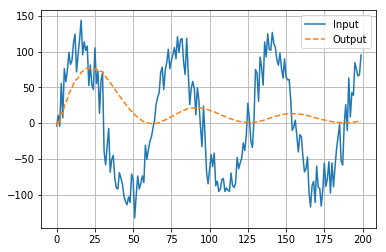

In [49]:
test_updater(RunningAvg())

It works fine, but the code is quite verbose, and we had to write a whole class just to build quite a simple thing. Let's write a version using the `yield` statement:

In [50]:
def averager():
    running_sum = yield
    count = 1
    while True:
        running_sum += yield running_sum/count
        count += 1

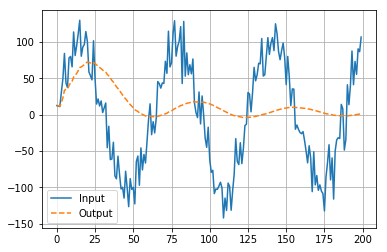

In [51]:
avg = averager()
next(avg)
test_updater(avg)

Not only does that code look much cleaner and it is just one function, but it is also slightly faster as it avoids the overheads of a whole class:

In [52]:
def test(updater, size=1_000_000):
    """Test performance of the updater by running 
    it on a large sequence of inputs"""
    t = arange(size)
    test_input = 100*sin(0.1*t)+randn(size)*20
    output = [updater.send(i) for i in test_input]
    return output

In [53]:
%%timeit
u = averager()
next(u)
test(u)

890 ms ± 35.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
%%timeit
u = RunningAvg()
test(u)

1.09 s ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


![](compare.png)

# Stacking generators
We can have generators which yield elements from another generator.

In [33]:
def gen1():
    yield 'gen1 a'
    yield 'gen1 b'
    yield 'gen1 c'

In [34]:
def gen2():
    for i in gen1():
        yield i
    yield 'd'
    yield 'e'

The `gen2` object yields elements from both generators sequentially

In [35]:
for i in gen2():
    print(i)

gen1 a
gen1 b
gen1 c
d
e


A shorthand for the loop over `gen1` is `yield from`.

In [37]:
def gen3():
    yield from gen1()
    yield 'd'
    yield 'e'

In [38]:
for i in gen3():
    print(i)

gen1 a
gen1 b
gen1 c
d
e


The `yield from gen` expression can be roughly translated to:
    
    for i in gen:
        yield i
However, it has some more subtleties which we will get into later.

## Example of stacking generators
One neat example of stacked generators is binary tree traversal. Recall that you can traverse a binary tree in three ways: 

* In-order
* Pre-order
* Post-order

Before we get into generators, let's write some simple code to setup a binary tree, and then write an inorder traversal function without using generators.

In [39]:
class BinaryTree():
    def __init__(self, data, left=None, right=None):
        self.data = data
        self.left = left
        self.right = right

Let's make a simple binary tree with 6 elements:

In [40]:
one, three, six = BinaryTree(1),BinaryTree(3),BinaryTree(6)
two = BinaryTree(2,one,three)
five = BinaryTree(5,left=None,right=six)
four = BinaryTree(4,two,five)
root = four

![binary tree](binary_tree.png)

Inorder traversal without using generators:

In [41]:
def inorder_list(btree):
    if btree==None:
        return []
    left = inorder_list(btree.left)
    right = inorder_list(btree.right)
    return left + [btree.data] + right

In [42]:
inorder_list(root)

[1, 2, 3, 4, 5, 6]

Preorder traversal

In [43]:
def preorder_list(btree):
    if btree==None:
        return []
    left = preorder_list(btree.left)
    right = preorder_list(btree.right)
    return [btree.data] + left  + right

In [44]:
preorder_list(root)

[4, 2, 1, 3, 5, 6]

We face the same issues of memory if the tree is very large, as the traversal returns the whole list at once. 

Let's write a version using stacked generators:

In [45]:
def inorder_gen(btree):
    if btree != None:
        yield from inorder_gen(btree.left)
        yield btree.data
        yield from inorder_gen(btree.right)

In [46]:
g = inorder_gen(root)
for i in g:
    print(i, end=' ')

1 2 3 4 5 6 

It's simple to change it to preorder:

In [47]:
def preorder_gen(btree):
    if btree != None:
        yield btree.data
        yield from preorder_gen(btree.left)
        yield from preorder_gen(btree.right)

In [48]:
g = preorder_gen(root)
for i in g:
    print(i, end=' ')

4 2 1 3 5 6 

This version is much more sleek and memory efficient.

# Digging deeper into `yield from`

The above example showed that `yield from` expands generators within other generators and allows us to stack them. However, the `yield from` statement is much more that just a for loop.

* The for loop expansion doesn't work if we send values into the nested generator, but `yield from` takes care of that.

* Putting things on the left hand side of `yield from` works differently from just a `yield`. This functionality is what lies at the heart of _asynchronous concurrency_ in python.

# Coroutines

Broadly, coroutines are functions that transfer control between each other, while maintaining their local namespace and state. 

We noted earlier that generators are like 'stateful' functions, whose execution can be 'paused' at `yield` statements.

These characteristics are exactly those of a _coroutine_ - the basic unit in async control flow.

The benefit of having such a block is that a coroutine for reading or writing (I/O) can send control to some other coroutine while waiting for results from the I/O operation. This minimizes idle time of the CPU.

# Example

In [49]:
def sum_n(n, name):
    s = 0
    while n>0:
        s += n
        n -= 1
        print(f"{name} s = {s}")
        yield
    
    return s

This 'coroutine' finds the sum of natural numbers until the given number, in reverse order. It has a `yield` after each step in the loop, so that it can be paused. Notice that it also __returns__ the sum at the end.

In [50]:
def print_result(coroutine):
    result = yield from coroutine
    print(f"Result = {result}")

This one just prints the result from another coroutine. Notice how `yield from` is used on the right hand side of an assignment. The value of `result` equals whatever the `coroutine` _returns_. 

Now, we can execute multiple coroutines concurrently using an _event loop_. I'm going to show a basic version of an event loop which just executes tasks using a round robin schedule.

In [51]:
def run(tasks):
    """Run the list of tasks until completion"""
    while tasks:
        to_run = tasks[0] # get the first task in the list
        
        try: # try to run it
            next(to_run)
        except StopIteration as e:
            # if stop iteration is raised, that means that the task is complete
            print(f'Completed task')
            del tasks[0] # remove it from the task queue
        else:
            # if it isn't raised, move it to the end of the queue
            del tasks[0]
            tasks.append(to_run)

Let's use this basic event loop to run two of the sum coroutines concurrently. We'll wrap the sum coroutines using the `print_result` coroutine as well.

In [52]:
run([print_result(sum_n(3, 'three')), 
     print_result(sum_n(5, 'five'))])

three s = 3
five s = 5
three s = 5
five s = 9
three s = 6
five s = 12
Result = 6
Completed task
five s = 14
five s = 15
Result = 15
Completed task


We can see that the two coroutines are executed alternatingly, and not one after the other. This is the essence of async concurrency. 

# `asyncio` in Python

We can use the keywords `async` and `await` to explicitly define coroutines. They work using the same principles as the `yield from` statement.

The `asyncio` library also features an event loop, along with some useful async coroutines like sleep and I/O.

Let's look at a simple coroutine again, but add some delays:

In [74]:
import asyncio

async def countdown(name, n, dur, async_sleep=True):
    s = 0
    while n>0:
        s += n
        n -= 1
        print(f"{name} s = {s}")
        # which type of delay to use?
        if async_sleep:
            await asyncio.sleep(dur)
        else:
            time.sleep(dur)
    return s

In python 3.7, you can concurrently run multiple coroutines by gathering them into a single main entry point:

In [71]:
async def main(async_sleep):
    await asyncio.gather(
        countdown("three", 3, dur=2, async_sleep=async_sleep), 
        countdown("five", 5, dur=1, async_sleep=async_sleep)
    )

Let's compare the two types of sleeps:

In [73]:
t = time.time()
await main(async_sleep=False) # asyncio.run(main(async_sleep=False)) in a script
print(f"{time.time()-t:.2f} seconds")

three s = 3
three s = 5
three s = 6
five s = 5
five s = 9
five s = 12
five s = 14
five s = 15
11.02 seconds


In [72]:
t = time.time()
await main(async_sleep=True) # asyncio.run(main(async_sleep=True)) in a script
print(f"{time.time()-t:.2f} seconds")

three s = 3
five s = 5
five s = 9
three s = 5
five s = 12
five s = 14
three s = 6
five s = 15
6.01 seconds


# Summary

* We started off by looking at lazy iteration, and generators were a very convenient way of making these types of iterators.

* Using one line generator expressions and stacked generators, we made a pretty nice declarative style of dealing with data pipelines.

* We made some nifty tools using the sending to generators functionality.

* By digging deeper into `yield from`, we saw that the main power of the `yield` keyword was the ability to pause function execution and maintain state. This is the foundation of asynchronous concurrency.

# Thanks for Listening

You can find the code for this talk on my github - [rajatvd](https://github.com/rajatvd).

Blog - [rajatvd.github.io](https://rajatvd.github.io/)

Twitter - @rajat_vd

Feel free to contact me at rajatvd@gmail.com!